In [1]:
import os
import uuid
from typing import List
from typing_extensions import TypedDict
from IPython.display import Image, display


from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import SKLearnVectorStore
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import JsonOutputParser, StrOutputParser
from langchain.schema import Document
from langgraph.graph import START, END, StateGraph
from langchain_community.tools.tavily_search import TavilySearchResults
from pprint import pprint


from typing import Literal

from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field

from langchain.document_loaders import HuggingFaceDatasetLoader

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [2]:
def initialize_llm():
    # we are using gemini model. You can use different models.
    from langchain.chat_models import init_chat_model
    from dotenv import load_dotenv  # used to store secret stuff like API keys or configuration values

    load_dotenv()

    llm = init_chat_model(
        "azure_openai:gpt-4o",
        azure_deployment="gpt4o",
    )
    metadata = f"CRAG, gpt4o"
    return llm, metadata

In [3]:
llm, metadata = initialize_llm()

In [4]:
class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    datasource: Literal["transformer", "web_search"] = Field(
        ...,
        description="""
        
        Given a user question choose to route it to 
        transformer store or web search."""
    )


structured_llm_router = llm.with_structured_output(RouteQuery)

# Prompt
system = """
You are an expert at routing a user question to a 
transformer store or web search.
Transformer store has information about transformer models, guides, and tutorials.
Web search has information about current events and news.
You must choose the most relevant datasource to answer the question.
"""
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

question_router = route_prompt | structured_llm_router
print(
    question_router.invoke(
        {"question": "What is the difference between GPT-4 and GPT-3?"}
    )
)
print(question_router.invoke({"question": "What is the capital of India?"}))

datasource='transformer'
datasource='web_search'


In [5]:
url = os.getenv("QDRANT_URL")
api_key = os.getenv("QDRANT_KEY")
collection_name = "transformers_docs"

In [6]:
from langchain_qdrant import QdrantVectorStore

c:\Ambarish\qdrant_langchain_langraph_advanced\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
model_name = "sentence-transformers/all-mpnet-base-v2"
model_kwargs = {'device': 'cpu'}
encode_kwargs = {'normalize_embeddings': False}
embeddings = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)

In [8]:
qdrant = QdrantVectorStore.from_existing_collection(
    embedding=embeddings,
    collection_name=collection_name,
    url=url,
    api_key=api_key,
)

In [9]:
retriever  = qdrant.as_retriever(search_type="similarity", 
                                 search_kwargs={"k": 4})

In [10]:
### Generate

from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = hub.pull("rlm/rag-prompt")


# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Chain
rag_chain = prompt | llm | StrOutputParser()

c:\Ambarish\qdrant_langchain_langraph_advanced\.venv\Lib\site-packages\langsmith\client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [11]:
from typing import List

from typing_extensions import TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    generation: str
    documents: List[str]

In [12]:
from langchain.schema import Document

In [13]:
def retrieve_and_generate(state):
    """
    Retrieve documents and generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New keys added to state, documents and generation, that contains retrieved documents and LLM generation
    """
    print("---RETRIEVE AND GENERATE---")
    question = state["question"]
    # Retrieval
    docs = retriever.invoke(question)
    documents = "\n".join([d.page_content for d in docs])
    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}

In [14]:
### Search

from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)

C:\Users\Ambarish Ganguly\AppData\Local\Temp\ipykernel_8176\730760015.py:5: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  web_search_tool = TavilySearchResults(k=3)


In [15]:
def web_and_generate(state):
    """
    Web search and generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New keys added to state, documents and generation, that contains retrieved documents and LLM generation
    """
    print("---WEB SEARCH AND GENERATE---")
    question = state["question"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)

    # RAG generation
    generation = rag_chain.invoke({"context": [web_results], "question": question})
    return {"documents": [web_results], "question": question, "generation": generation}

In [16]:
### Answer Grader


# Data model
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )


structured_llm_grader = llm.with_structured_output(GradeAnswer)

# Prompt
system = """You are a grader assessing whether an answer addresses / resolves a question \n 
     Give a binary score 'yes' or 'no'. 
    'No' means that the answer does not resolve the question.
    Yes' means that the answer resolves the question.
     """

answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

answer_grader = answer_prompt | structured_llm_grader

In [17]:
def grade_answer(state):
    """
    Grade the answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, grade, that contains binary score 'yes' or 'no'
    """
    print("---GRADE ANSWER---")
    question = state["question"]
    generation = state["generation"]
    grade = answer_grader.invoke({"question": question, "generation": generation})
    print(f"Grade: {grade.binary_score}")
    return grade.binary_score


In [18]:
def route_question(state):
    """
    Route question to web search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})
    if source.datasource == "web_search":
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "web_search"
    elif source.datasource == "transformer":
        print("---ROUTE QUESTION TO RAG---")
        return "transformer"


In [19]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("web_search", web_and_generate)  # web search
workflow.add_node("transformer", retrieve_and_generate)  # retrieve

workflow.add_edge(START,"transformer")  # start with transformer

workflow.add_edge("web_search", END)
workflow.add_conditional_edges("transformer",
                                grade_answer, 
                                {"yes": END, 
                                 "no": "web_search"
                                 })

# Compile
app = workflow.compile()

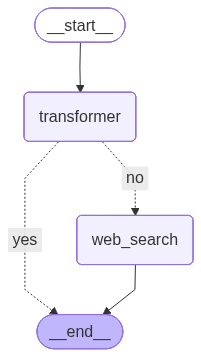

In [20]:
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [23]:
question = "What is LLAMA?"

In [24]:
# Run
inputs = {"question": question}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        #pprint(value["generation"], indent=2, width=80, depth=None)
    pprint("------------------")

# Final generation
pprint(value["generation"])

---RETRIEVE AND GENERATE---
---GRADE ANSWER---
Grade: yes
"Node 'transformer':"
'------------------'
('LLAMA is a collection of foundation language models ranging from 7 billion '
 'to 65 billion parameters, designed to be trained on publicly available '
 'datasets. LLAMA 2 is an updated version, featuring models from 7 billion to '
 '70 billion parameters, optimized for dialogue use cases and fine-tuned for '
 'improved safety and helpfulness in chat applications. Both versions are '
 'open-source and intended for research and development in large language '
 'models.')
